In [1]:
import pandas as pd
import numpy as np

data2019 = pd.read_csv("./FullData2019.csv")
data2016 = pd.read_csv("./FullData2016.csv")
def FCSStaus(val):
    if val <=21:
        return 1
    else:
        return 0
# create the binary food insecurity indicator
data2019['FCSStaus'] = data2019['FCS'].apply(FCSStaus)
data2016['FCSStaus'] = data2016['FCS'].apply(FCSStaus)
# create a lagged FCS
data2016['dismerge'] = data2016['s1aq2a'].str.upper()
mg2016 = data2016[['FCSStaus','dismerge']].groupby('dismerge').mean().reset_index()
mg2016.rename(columns={'dismerge':'s1aq2a', 'FCSStaus':'FCSStaus_lag'}, inplace=True)
data2019['FCSStaus_lag'] = pd.merge(data2019, mg2016, on='s1aq2a', how='left')['FCSStaus_lag']

# imputation for NA, with mode  
individual = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'ShareToilet', 'Income', 'Kind Income Ratio', 'Salt', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd',
       'OwnNow_ArgLand', 'valueNow_ArgLand', 'Own1yrAgo_ArgLand',
       'ValueAgo_ArgLand', 'OwnNow_TV', 'valueNow_TV', 'Own1yrAgo_TV',
       'ValueAgo_TV', 'OwnNow_FixPhone', 'valueNow_FixPhone',
       'Own1yrAgo_FixPhone', 'ValueAgo_FixPhone', 'OwnNow_MobilePhone',
       'valueNow_MobilePhone', 'Own1yrAgo_MobilePhone', 'ValueAgo_MobilePhone','OwnNow_Refrigerator', 'valueNow_Refrigerator',
       'Own1yrAgo_Refrigerator', 'ValueAgo_Refrigerator', 'OwnNow_Furniture',
       'valueNow_Furniture', 'Own1yrAgo_Furniture', 'ValueAgo_Furniture','OwnNow_Cooker', 'valueNow_Cooker', 'Own1yrAgo_Cooker',
       'ValueAgo_Cooker', 'OwnNow_Livestock', 'valueNow_Livestock','Own1yrAgo_Livestock', 'ValueAgo_Livestock','valueNowTotal',
       'ValueAgoTotal','FamilySize','SelfStapleTypes','FCSStaus_lag'] # ShareToilet and Salt are dummies 

for i in individual: 
    # data2016[i].fillna(data2016[i].mode()[0],inplace=True)
    data2019[i].fillna(data2019[i].mode()[0],inplace=True)
# wkd2016 = pd.get_dummies(data2016,columns=["ShareToilet","Salt"])
wkd2019 = pd.get_dummies(data2019,columns=["ShareToilet","Salt"])
wkd2019_2 = pd.get_dummies(wkd2019,columns=["IncomeStab",'SubjectivePoverty', 'RelLivStandard','LivStandChange'])
# frequency encoding 
# freq = ['HouseType', 'RoofType', 'WaterSource',
#        'DistDrinkingWater', 'SubjectivePoverty', 'RelLivStandard',
#        'IncomeStab', 'LivStandChange']
freq = ['HouseType', 'RoofType', 'WaterSource']

wkd2019_2['DistDrinkingWaterBig3'] = wkd2019_2['DistDrinkingWater'].replace({'0-3':0, "3-5":1, "5-8":1,'8 or more KMs':1 })
# for i in freq: 
#     freqf = data2016.groupby(i).size()/len(data2016)
#     wkd2016[f"{i}_feq"] = wkd2016[i].apply(lambda x : freqf[x])
for j in freq: 
    freqf = wkd2019_2.groupby(j).size()/len(wkd2019_2)
    wkd2019_2[f"{j}_feq"] = wkd2019_2[j].apply(lambda x : freqf[x])
    
wkd2019_2['fatalitiesMean'] = wkd2019_2[['fatalities', 'fatalities lag1', 'fatalities lag2', 'fatalities lag3',
       'fatalities lag4']].sum(axis=1)
wkd2019_2['temperatureMean'] = wkd2019_2[['temperature', 'temperature lag1',
       'temperature lag2', 'temperature lag3', 'temperature lag4']].mean(axis=1)
wkd2019_2['precipitationMean'] = wkd2019_2[['precipitation', 'precipitation lag1', 'precipitation lag2',
       'precipitation lag3', 'precipitation lag4']].mean(axis=1)
wkd2019_2['NDVIMean'] = wkd2019_2[['NDVI', 'NDVI lag1', 'NDVI lag2', 'NDVI lag3', 'NDVI lag4']].mean(axis=1)
wkd2019_2['NDVI Anomaly Mean'] = wkd2019_2[['NDVI Anomaly',
       'NDVI Anomaly lag1', 'NDVI Anomaly lag2', 'NDVI Anomaly lag3',
       'NDVI Anomaly lag4']].mean(axis=1)

# feature engineering 
value_list = ['valueNow_ArgLand', "Income", 
       'valueNow_TV', 'valueNow_FixPhone',  'valueNow_MobilePhone', 'valueNow_Refrigerator', 'valueNow_Furniture', 
       'valueNow_Cooker', 'valueNow_Livestock', 'valueNowTotal', 'ValueAgoTotal']
value_list_new = [f'{i}_new' for i in value_list]
wkd2019_2[value_list_new] = np.log(wkd2019_2[value_list] + 1)*10
wkd2019_2['FamilySize_new'] =  np.log(wkd2019_2['FamilySize'])*10
wkd2019_2['SelfStapleTypes_new'] =  np.log(wkd2019_2['SelfStapleTypes'] + 1)*10

macrologList = ['NL_District', 'fatalitiesMean', 'temperatureMean',
       'precipitationMean', 'NDVIMean', 'NDVI Anomaly Mean', 'Kind Income Ratio', 
       'Average (mm)', '1 Month Anomaly (%)', '3 Months Anomaly (%)','MaleRatio', 'AvgAge' ]
macrologList_new = [f'{i}_log' for i in macrologList]
wkd2019_2[macrologList_new] = np.log(wkd2019_2[macrologList]+1)*10

time_splitted_data_1920 = { }

for y in [2019, 2020]:
    for m in range(1,13):
        if wkd2019_2.query("year == @y and month == @m").shape[0] != 0: 
            time_splitted_data_1920[f"{y}_{m}"] = wkd2019_2.query("year == @y and month == @m").reset_index(drop = True)
        else: 
            continue 

In [2]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer
import matplotlib.pyplot as plt
from sklearn import metrics
from python_functions.modues import StandardizerTrainTest, resampling, XGBmodelfit
from python_functions.modues import _Flexible_test_prediction, Metrics_TradeOff_Plot, variable_distribution_crosscheck
import seaborn as sns

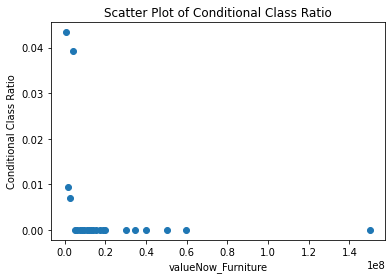

In [3]:
import numpy as np
import matplotlib.pyplot as plt

varname = 'valueNow_Furniture'
variable_distribution_crosscheck(varname, wkd2019_2)

In [5]:
predictorList = ['FCSStaus_lag', 'urban','NL_District_log', 
       'precipitationMean', 'NDVI Anomaly Mean',
       'Average (mm)',  '1 Month Anomaly (%)', '3 Months Anomaly (%)', 
       'fatalitiesMean_log','temperatureMean_log','NDVIMean_log',
       'Kind Income Ratio','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd', 'ShareToilet_Yes', 'Salt_Yes',
       'HouseType_feq', 'RoofType_feq', 'WaterSource_feq', 'IncomeStab_Somewhat stable',
       'IncomeStab_Very unstable',
       'SubjectivePoverty_Neither poor nor rich', 'SubjectivePoverty_Poor',
       'SubjectivePoverty_Very poor', 'RelLivStandard_Better off',
       'RelLivStandard_Same', 'RelLivStandard_Worse off',
       'LivStandChange_Decreased', 'LivStandChange_Increased',
       'LivStandChange_Stayed at the same', 'DistDrinkingWaterBig3', 'FamilySize', 
       'SelfStapleTypes', 'valueNow_MobilePhone', 'valueNowTotal', 'valueNow_Furniture', 
        'valueNow_MobilePhone_new', 'valueNow_ArgLand_new', 'valueNow_ArgLand', 'valueNow_Livestock', 
       'valueNow_Furniture_new', 'valueNow_Livestock_new', 'valueNowTotal_new', 'Income_new', 'Income', 
       'ValueAgoTotal_new', 'valueNow_FixPhone',  
       'valueNow_Refrigerator']

binaryList = ['urban','Salt_Yes','ShareToilet_Yes','SelfArg', 'SelfHerd', 'IncomeStab_Somewhat stable',
       'IncomeStab_Very unstable','SubjectivePoverty_Neither poor nor rich', 'SubjectivePoverty_Poor',
       'SubjectivePoverty_Very poor', 'RelLivStandard_Better off',
       'RelLivStandard_Same', 'RelLivStandard_Worse off',
       'LivStandChange_Decreased', 'LivStandChange_Increased', 
       'LivStandChange_Stayed at the same','DistDrinkingWaterBig3']

freqList = [f"{i}_feq" for i in freq]

# nonstdList = ['valueNow_ArgLand_new', 'valueNow_TV_new', 'valueNow_FixPhone_new',
#        'valueNow_MobilePhone_new', 'valueNow_Refrigerator_new',
#        'valueNow_Furniture_new', 'valueNow_Cooker_new',
#        'valueNow_Livestock_new', 'valueNowTotal_new', 'FamilySize_new',
#        'SelfStapleTypes_new']

nonstdList = []

standardizationList = list(set(predictorList) - set(binaryList) - set(freqList) - set(nonstdList))

In [6]:
sum(wkd2019_2[predictorList].isna().sum(axis=0))

0

#### Time

In [7]:
time_splitted_data_1920.keys()

dict_keys(['2019_9', '2019_10', '2019_11', '2019_12', '2020_1', '2020_2', '2020_7', '2020_8', '2020_9', '2020_10', '2020_11'])

In [8]:

date19List = [i for i in time_splitted_data_1920.keys()]
data19List = [i for i in time_splitted_data_1920.values()]

# here we generate the "time series" train and test data, we use the first 4 months in 19/20 data as the first set
# of training data, and then add one month in each round, the test data is the next month of the last train data 
trainDataStart = data19List[0].copy()

for i in range(1, 4):
    interTrainData = data19List[i].copy()
    trainDataStart = pd.concat([trainDataStart, interTrainData], axis=0)
    
trainData = {"train_3":trainDataStart.reset_index(drop = True)}
testData = {"test_3":data19List[4].reset_index(drop = True)}

for i in range(4, len(time_splitted_data_1920.keys()) - 1):
    interTrainData = pd.concat([trainData[f"train_{i - 1}"], data19List[i].copy()], axis=0)
    interTestData = data19List[i + 1].copy()
    trainData[f"train_{i}"] = interTrainData.reset_index(drop = True)
    testData[f"test_{i}"] = interTestData.reset_index(drop = True)
# standardize and resample 
StdTrain = {}
StdTest = {}
train19List = [i for i in trainData.values()]
test19List = [i for i in testData.values()]

for train, test, name1, name2 in zip(train19List, test19List,  trainData.keys(), testData.keys()):
    standardizedTrain, standardizedTest = StandardizerTrainTest(train[predictorList], test[predictorList], 
                                                                standardizationList, binaryList, freqList, nonstdList)
    standardizedTrain_withY = pd.concat([standardizedTrain,train['FCSStaus']], axis=1)
    standardizedTest_withY = pd.concat([standardizedTest,test['FCSStaus']], axis=1)
    StdTrain[f"{name1}"] = standardizedTrain_withY
    StdTest[f"{name2}"] = standardizedTest_withY

SMOTE_Train = {}
ADASYN_Train = {}
for train, name1 in zip(StdTrain.values(),  trainData.keys()):
    X_smote, Y_smote, X_ADA, Y_ADA = resampling(train[predictorList], train['FCSStaus'])
    SMOTE_Train[f"{name1}"] = pd.concat([X_smote, Y_smote], axis=1)
    ADASYN_Train[f"{name1}"] = pd.concat([X_ADA, Y_ADA], axis=1)
StdTrain['train_9'].shape

(12560, 51)

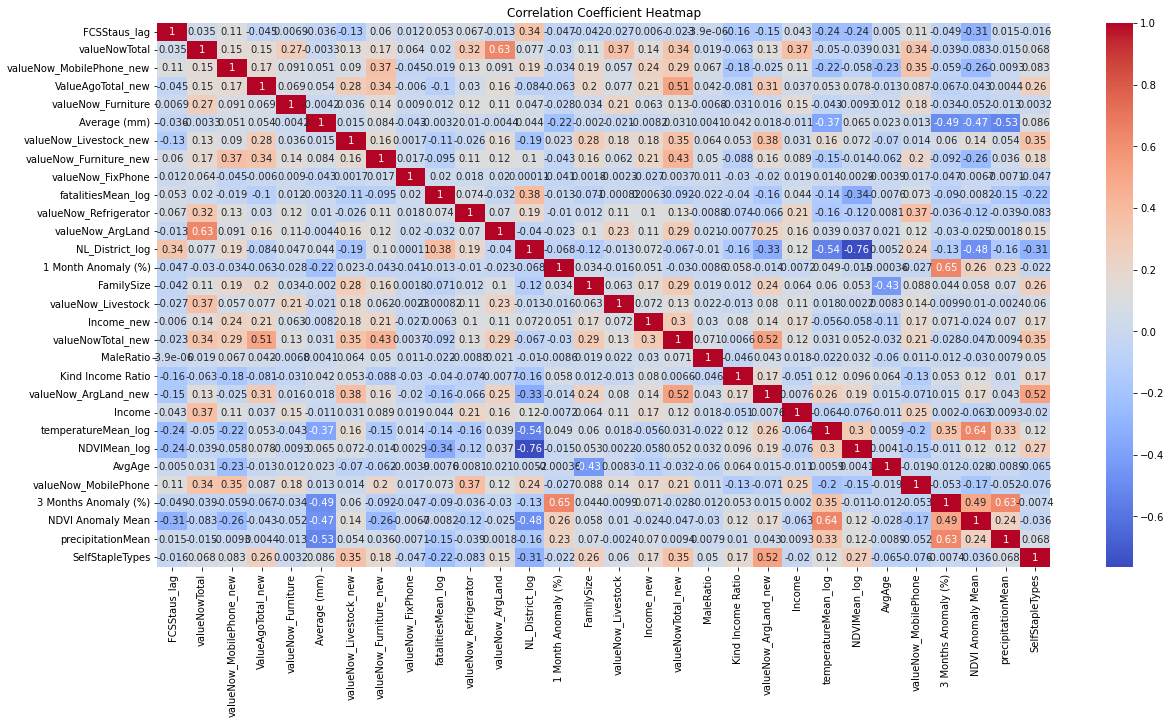

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = StdTrain['train_9'][standardizationList].corr()
# Plot heatmap
plt.figure(figsize=(20, 10))  # Set the size of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Coefficient Heatmap')
plt.savefig("./figures/Corre_Coef.png")

#### Basic Logistic

In [127]:
X_train = StdTrain['train_9'][predictorList]
Y_train = StdTrain['train_9']['FCSStaus']

X_test = StdTest['test_9'][predictorList]
Y_test = StdTest['test_9']['FCSStaus']

In [10]:
X_train = StdTrain['train_9'][predictorList]
Y_train = StdTrain['train_9']['FCSStaus']

X_test = StdTest['test_9'][predictorList]
Y_test = StdTest['test_9']['FCSStaus']

# scoring = make_scorer(recall_score, greater_is_better=True, average='binary')
# scoring = make_scorer(roc_auc_score, greater_is_better=True, average='binary')
scoring = 'roc_auc'

LR_l1 = LogisticRegression(penalty='l1',random_state=527, solver='liblinear' ,
                           max_iter=1000, class_weight = 'balanced')

grid = {"C":[10**i for i in range(-2,2,1)]}
crossval = GridSearchCV(LR_l1,grid,cv=5,scoring=scoring)

crossval.fit(X_train, Y_train)
crossval.best_params_

{'C': 0.1}

In [11]:
LR_l1 = LogisticRegression(penalty='l1',random_state=527,max_iter=1000,C=0.1, solver='saga' ,
                           class_weight = 'balanced')

LR_l1 = LogisticRegression(max_iter=1000)
LR_l1.fit(X_train, Y_train)

y_LRpred_test = LR_l1.predict(X_test)
y_LRpredprob_test = LR_l1.predict_proba(X_test)
y_LRpredprob_train = LR_l1.predict_proba(X_train)
report_test = classification_report(Y_test, y_LRpred_test,output_dict=True)
pd.DataFrame(report_test).T, confusion_matrix(Y_test, y_LRpred_test)

(              precision    recall  f1-score     support
 0              0.950667  0.998599  0.974044  714.000000
 1              0.666667  0.051282  0.095238   39.000000
 accuracy       0.949535  0.949535  0.949535    0.949535
 macro avg      0.808667  0.524941  0.534641  753.000000
 weighted avg   0.935958  0.949535  0.928528  753.000000,
 array([[713,   1],
        [ 37,   2]], dtype=int64))

In [79]:
# new_threshold = 0.011
# y_new_prediction = np.where(y_LRpredprob_test[:,1] >= new_threshold, 1, 0)
# report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
# pd.DataFrame(report_pre).T

In [12]:
roc_auc_score(Y_train, y_LRpredprob_train[:,1]) ,roc_auc_score(Y_test, y_LRpredprob_test[:,1])

(0.8441754726208419, 0.8098829275299864)

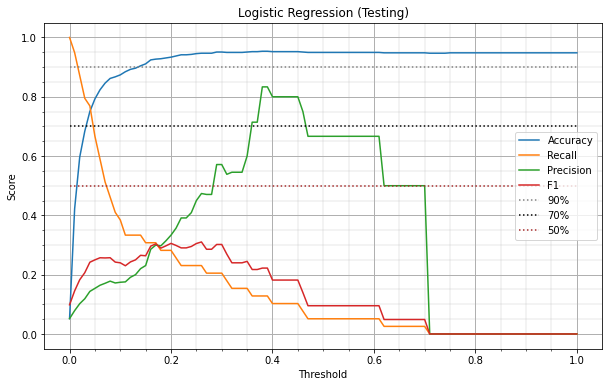

In [100]:
f_one_LR, acc_LR, recall_LR, precision_LR = Metrics_TradeOff_Plot(y_LRpredprob_test[:,1], 
                Y_test, "Logistic Regression (Testing)", "./figures/Tradeoff_LR_basic_testing.png")

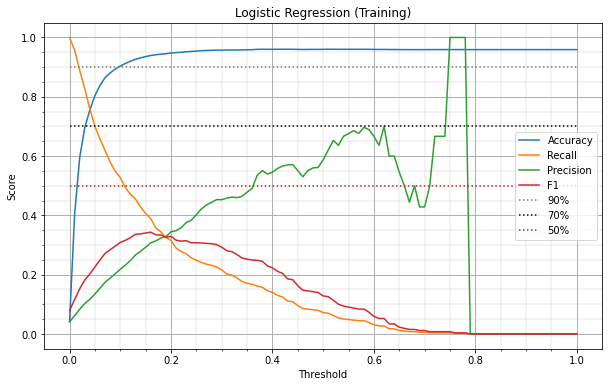

In [99]:
f_one_LRTr, acc_LRTr, recall_LRTr, precision_LRTr = Metrics_TradeOff_Plot(y_LRpredprob_train[:,1], 
                Y_train, "Logistic Regression (Training)", "./figures/Tradeoff_LR_basic_training.png")

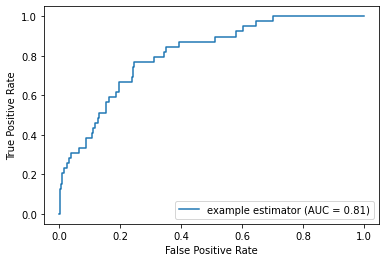

In [15]:
fpr_LRBasic, tpr_LRBasic, thresholds = metrics.roc_curve(Y_test, y_LRpredprob_test[:,1])
roc_auc_LRBasic = metrics.auc(fpr_LRBasic, tpr_LRBasic)
display = metrics.RocCurveDisplay(fpr=fpr_LRBasic, tpr=tpr_LRBasic, roc_auc=roc_auc_LRBasic,
                               estimator_name='example estimator')
display.plot()
plt.show()

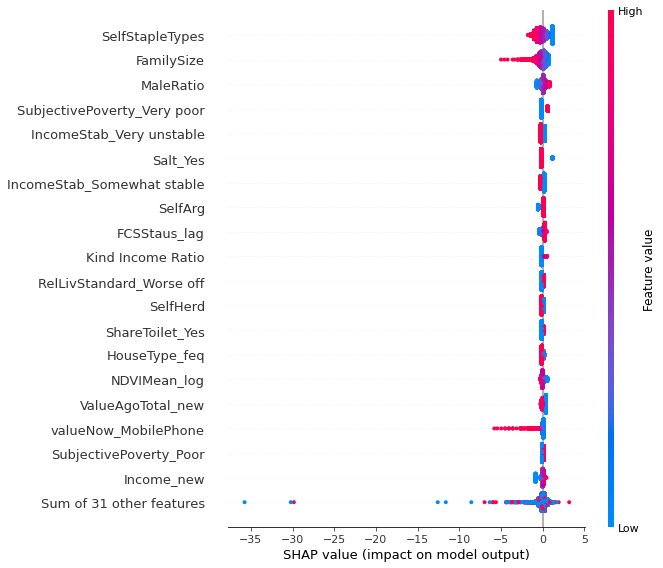

In [103]:
X_present = X_train.sample(frac=1)
explainer = shap.Explainer(LR_l1, masker=X_present)
shap_values = explainer(X_present)
shap.plots.beeswarm(shap_values, max_display = 20)

In [ ]:
feature_names = X_train.columns

rf_resultX = pd.DataFrame(shap_values.values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shapImportance_LR = set(shap_importance.iloc[0:30,0])

#### Basic RF

In [16]:
from sklearn.ensemble import RandomForestClassifier

X_train = StdTrain['train_9'][predictorList]
Y_train = StdTrain['train_9']['FCSStaus']

X_test = StdTest['test_9'][predictorList]
Y_test = StdTest['test_9']['FCSStaus']

# scoring = make_scorer(recall_score, greater_is_better=True, average='binary')
# scoring = make_scorer(f1_score, greater_is_better=True, average='binary')
scoring = 'roc_auc'

RF = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[500],'max_depth':[3, 5, 7], 'max_features' : [3, 5,7,9]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)

crossval_rf.fit(X_train, Y_train)
crossval_rf.best_params_, crossval_rf.best_score_

({'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 500},
 0.8193232439934498)

In [29]:
RF = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, class_weight='balanced')
scoring = 'roc_auc'
grid_rf = {"min_samples_leaf":[100,150],'max_depth':[5], 'max_features' : [9]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)

crossval_rf.fit(X_train, Y_train)
crossval_rf.best_params_, crossval_rf.best_score_

({'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 100},
 0.8464199307400943)

In [30]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, **crossval_rf.best_params_, 
                            class_weight='balanced')

RF.fit(X_train, Y_train)
y_RFpredProb_train = RF.predict_proba(X_train)[:, 1]
y_RFpred_test = RF.predict(X_test)
y_RFpredProb_test = RF.predict_proba(X_test)[:, 1]

report_pre = classification_report(Y_test, y_RFpred_test, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.973913,0.784314,0.868891,714.000000
1,0.134831,0.615385,0.221198,39.000000
accuracy,0.775564,0.775564,0.775564,0.775564
macro avg,0.554372,0.699849,0.545044,753.000000
weighted avg,0.930455,0.775564,0.835345,753.000000


In [31]:
roc_auc_score(Y_train, y_RFpredProb_train), roc_auc_score(Y_test, y_RFpredProb_test)

(0.8881301961159265, 0.8131868131868132)

In [ ]:
# new_threshold = 0.36
# y_new_prediction = np.where(y_RFpredProb_test >= new_threshold, 1, 0)
# report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
# pd.DataFrame(report_pre).T

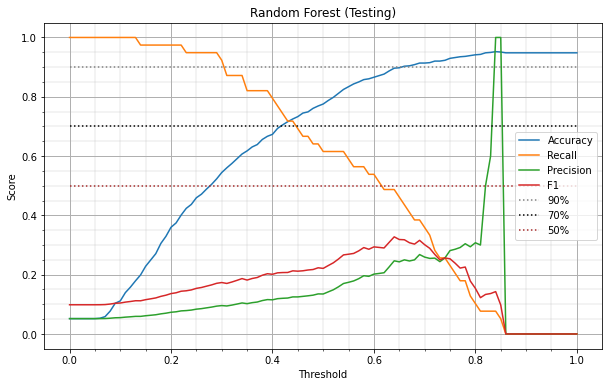

In [98]:
f_one_RF, acc_RF, recall_RF, precision_RF = Metrics_TradeOff_Plot(y_RFpredProb_test, 
                Y_test, 'Random Forest (Testing)', "./figures/Tradeoff_RF_basic_test.png")

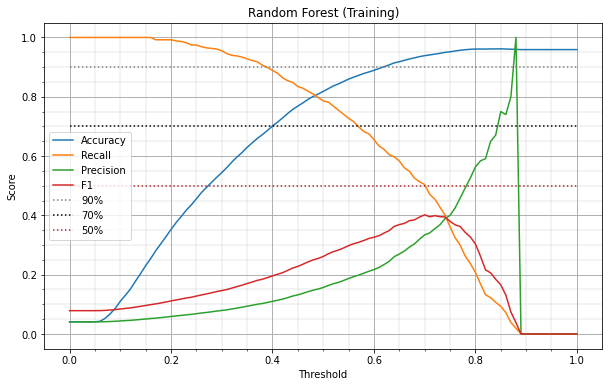

In [97]:
f_one_RFtr, acc_RFtr, recall_RFtr, precision_RFtr = Metrics_TradeOff_Plot(y_RFpredProb_train, 
                Y_train, 'Random Forest (Training)', 
                "./figures/Tradeoff_RF_basicTraining_train.png")

In [ ]:
y_RFpred_train = RF.predict(X_train)
report_train = classification_report(Y_train,y_RFpred_train,output_dict=True)
pd.DataFrame(report_train).T

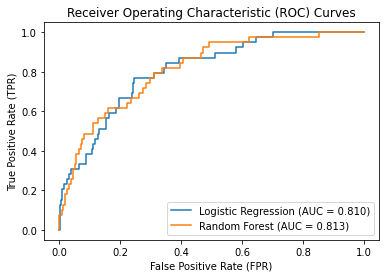

In [34]:
fpr_RFbasic, tpr_RFbasic, thresholds = metrics.roc_curve(Y_test, y_RFpredProb_test)
roc_auc_RFbasic = metrics.auc(fpr_RFbasic, tpr_RFbasic)
# display = metrics.RocCurveDisplay(fpr=fpr_RFbasic, tpr=tpr_RFbasic, roc_auc=roc_auc_RFbasic,
#                                estimator_name='example estimator')
# Plot the ROC curves
plt.plot(fpr_LRBasic, tpr_LRBasic, label='Logistic Regression (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_LRpredprob_test[:,1])))
plt.plot(fpr_RFbasic, tpr_RFbasic, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_RFpredProb_test)))
# Add labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


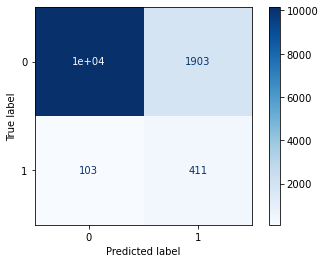

In [92]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(RF, StdTest['test_9'][predictorList], StdTest['test_9']['FCSStaus'], cmap=plt.cm.Blues)
plot_confusion_matrix(RF, X_train, Y_train, cmap=plt.cm.Blues)
plt.show()

In [ ]:
plot_confusion_matrix(RF, X_test, Y_test, cmap=plt.cm.Blues)
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

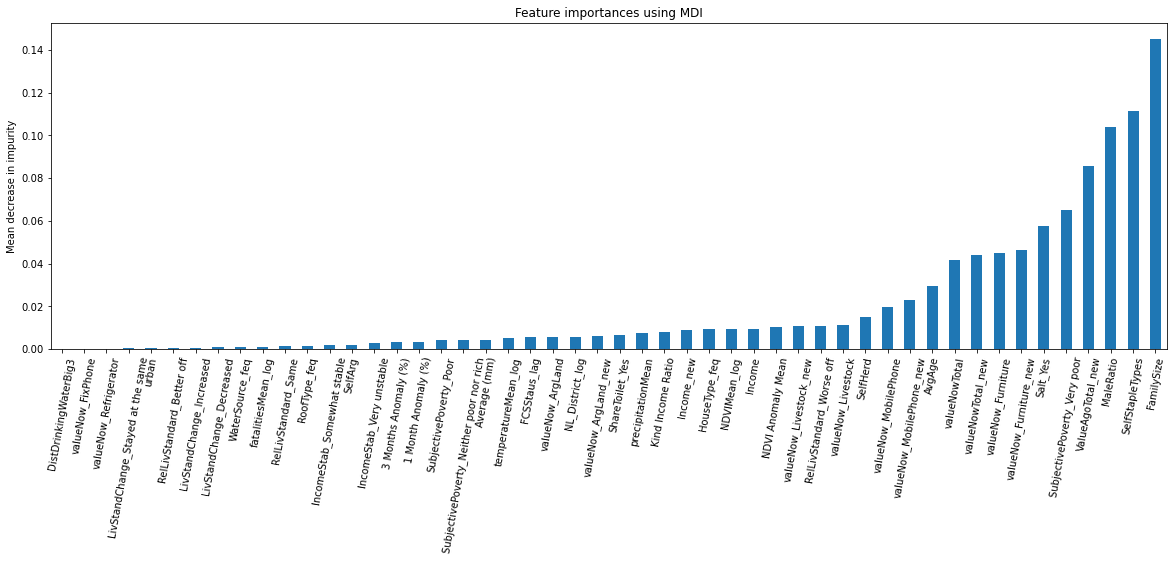

In [35]:
importances = RF.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(20, 6))
forest_importances.sort_values().plot.bar(ax=ax)
plt.xticks(rotation=80)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [40]:
RFImportance = set(forest_importances.sort_values(ascending=False)[0:30].index)

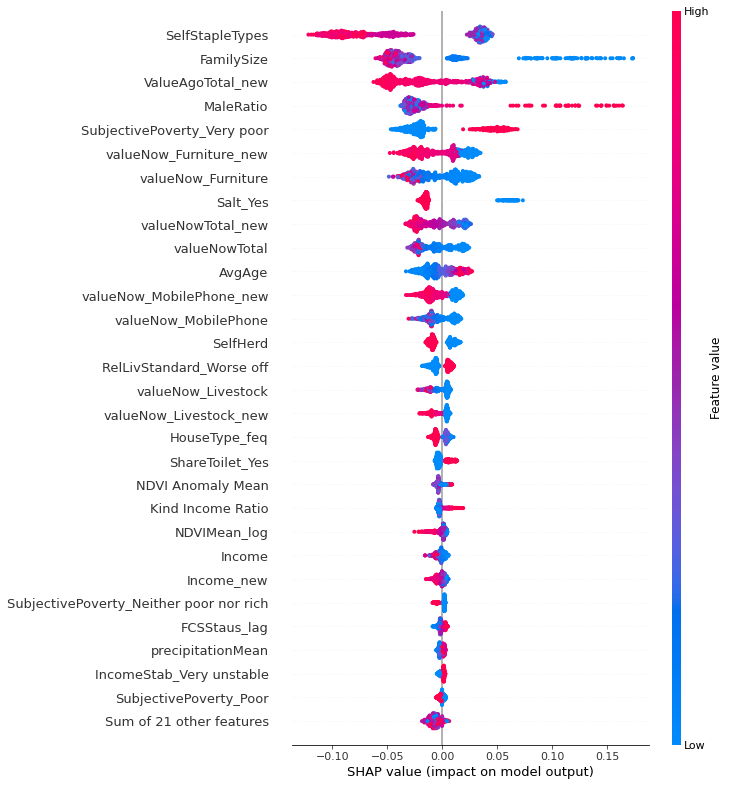

In [105]:
X_present = X_test.sample(frac=1)
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)
shap.plots.beeswarm(shap_values[:,:,1], max_display = 30)

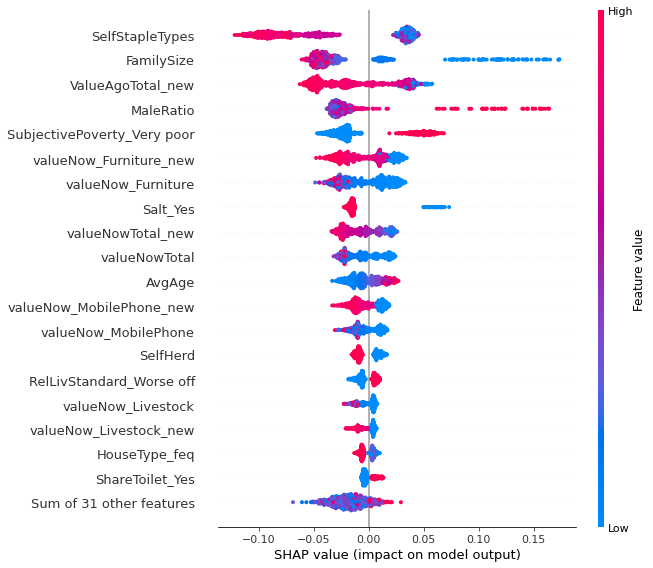

In [106]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 20)

In [38]:
feature_names = X_train.columns

rf_resultX = pd.DataFrame(shap_values[:,:,1].values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shapImportance_RF = set(shap_importance.iloc[0:30,0])

In [41]:
len(shapImportance_RF & RFImportance)

27

#### Basic XGBoost

In [42]:
import xgboost as xgb # use xgb.cv 
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 

In [51]:
# scoring = make_scorer(recall_score, greater_is_better=True, average='binary')
scoring = 'roc_auc' 
class_weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]
DataTrain = pd.concat([X_train,Y_train],axis=1)
xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight= class_weight,
 seed=27)
xgb_estimator, test_pred_prob, test_pred_class, train_pred_prob = XGBmodelfit(xgb1, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)


Model Report
AUC Score (Train): 0.976031
AUC Score (Test): 0.810996
Recall (Test): 0.538462


In [52]:
param_test1 = {
 'max_depth':[5,6,7],
 'min_child_weight':range(1,10,2)
}
# param_test1 = {
#  'max_depth':[5],
#  'min_child_weight': [9,10,11]
# }

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=150, max_depth=5,
 min_child_weight=1, gamma=1, reg_lambda = 100, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight= class_weight, seed=27), 
 param_grid = param_test1, scoring=scoring, n_jobs=-1, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 6, 'min_child_weight': 9}, 0.8569767718344815)

In [51]:
xgb1 = XGBClassifier(
 learning_rate =0.05, n_estimators=1000, **gsearch1.best_params_, 
 gamma=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight, seed=27)
xgb_estimator, test_pred_prob, test_pred_class, train_pred_prob = XGBmodelfit(xgb1, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)


Model Report
AUC Score (Train): 0.995453
AUC Score (Test): 0.821016
Recall (Test): 0.512821


In [52]:
xgb_estimator.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              n_estimators=163, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)>

In [53]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)],'max_depth': [6], 'min_child_weight': [9]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=107, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
 param_grid = param_test3, scoring=scoring, n_jobs=-1, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2, 'max_depth': 6, 'min_child_weight': 9}, 0.8538856316994338)

In [54]:
xgb2 = XGBClassifier( learning_rate =0.05, n_estimators=1000, **gsearch3.best_params_, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27)
xgb_estimator, test_pred_prob, test_pred_class, train_pred_prob = XGBmodelfit(xgb2, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)


Model Report
AUC Score (Train): 0.989251
AUC Score (Test): 0.815449
Recall (Test): 0.512821


In [55]:
xgb_estimator.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              n_estimators=110, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)>

In [56]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(4,9)],
 'gamma':[1],'max_depth': [6], 'min_child_weight': [9]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=200, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
 param_grid = param_test4, scoring=scoring ,n_jobs=-1, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7,
  'gamma': 1,
  'max_depth': 6,
  'min_child_weight': 9,
  'subsample': 0.8},
 0.8488479223466939)

In [49]:
param_test6 = {
     'subsample':[0.8],
 'colsample_bytree':[0.7],
 'gamma':[1],'max_depth': [6], 'min_child_weight': [9], 
 'reg_lambda':[1200, 1300, 1400]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27), 
 param_grid = param_test6, scoring=scoring , n_jobs=-1, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_, gsearch6.best_score_

({'colsample_bytree': 0.7,
  'gamma': 1,
  'max_depth': 6,
  'min_child_weight': 9,
  'reg_lambda': 1300,
  'subsample': 0.8},
 0.8480583227022821)

In [50]:
xgb3 = XGBClassifier( learning_rate =0.05, n_estimators=1000, **gsearch6.best_params_, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27)
xgb_estimator, test_pred_prob, test_pred_class, train_pred_prob = XGBmodelfit(xgb3, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)


Model Report
AUC Score (Train): 0.962509
AUC Score (Test): 0.841988
Recall (Test): 0.641026


In [53]:
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=5000, **gsearch6.best_params_,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=class_weight,seed=27)
xgb_estimator, test_pred_prob, test_pred_class, train_pred_prob = XGBmodelfit(xgb4, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)


Model Report
AUC Score (Train): 0.949866
AUC Score (Test): 0.841521
Recall (Test): 0.666667


In [91]:
report_pre = classification_report(Y_test, test_pred_class, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.977853,0.803922,0.882398,714.000000
1,0.156627,0.666667,0.253659,39.000000
accuracy,0.796813,0.796813,0.796813,0.796813
macro avg,0.567240,0.735294,0.568028,753.000000
weighted avg,0.935320,0.796813,0.849834,753.000000


In [55]:
confusion_matrix(Y_test,test_pred_class)

array([[574, 140],
       [ 13,  26]], dtype=int64)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


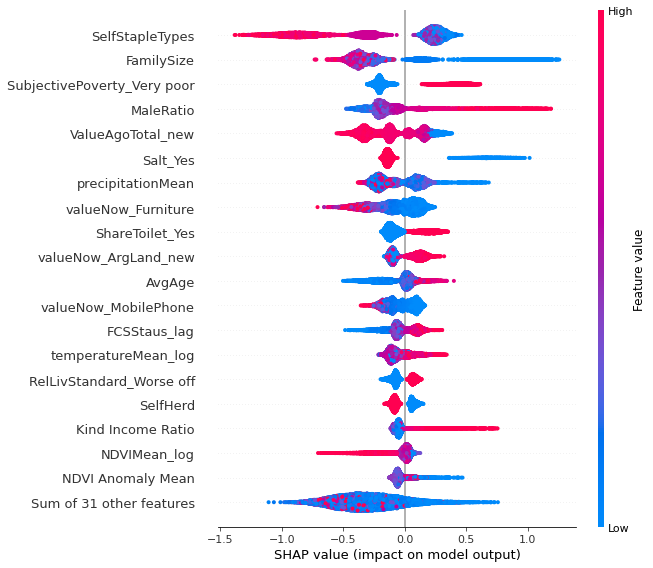

In [107]:
X_present = X_train.sample(frac=1)
explainer = shap.TreeExplainer(xgb_estimator, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)
fig = shap.plots.beeswarm(shap_values, max_display = 20)

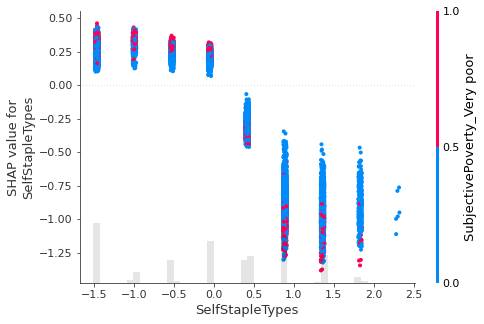

In [136]:
shap.plots.scatter(shap_values[:,"SelfStapleTypes"], color=shap_values[:,"SubjectivePoverty_Very poor"])

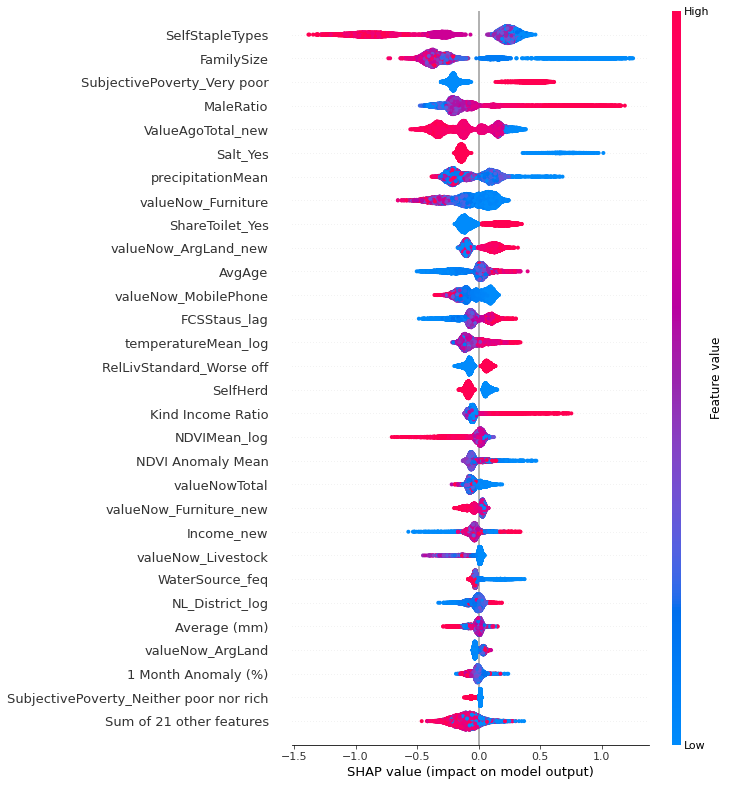

In [59]:
fig = shap.plots.beeswarm(shap_values, max_display = 30)

In [60]:
feature_names = X_train.columns

XGB_resultX = pd.DataFrame(shap_values.values, columns = feature_names)

vals = np.abs(XGB_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shapImportance_XGB = set(shap_importance.iloc[0:30,0])

In [ ]:
new_threshold = 0.03
y_new_prediction = np.where(test_pred_prob >= new_threshold, 1, 0)
report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
pd.DataFrame(report_pre).T, confusion_matrix(Y_test,y_new_prediction)

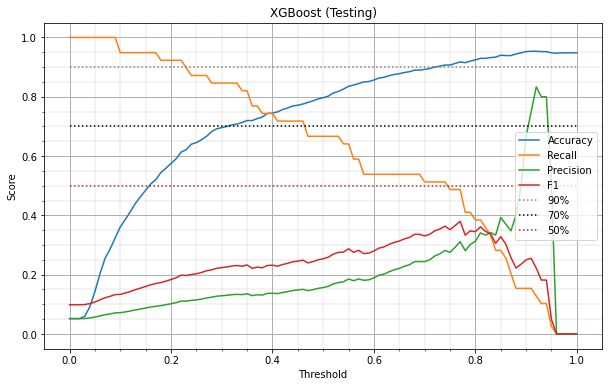

In [96]:
f_one_XGB, acc_XGB, recall_XGB, precision_XGB = Metrics_TradeOff_Plot(test_pred_prob, 
                Y_test, 'XGBoost (Testing)', "./figures/Tradeoff_XGB_basic_test.png")

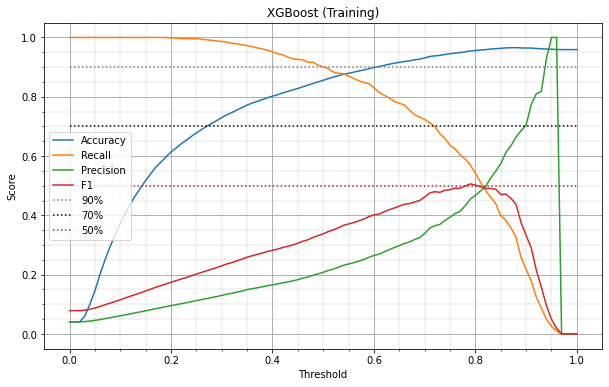

In [95]:
f_one_XGBTr, acc_XGBTr, recall_XGBTr, precision_XGBTr = Metrics_TradeOff_Plot(train_pred_prob, 
                Y_train, 'XGBoost (Training)', "./figures/Tradeoff_XGB_basic_train.png")

In [63]:
XGBtradeoff = pd.DataFrame(np.vstack([np.arange(0,101)/100,f_one_XGBTr, acc_XGBTr, recall_XGBTr, precision_XGBTr]).T, columns=['proba',"f1",'accuracy','recall','precision'])
le = XGBtradeoff['recall'] <= 0.71
be = XGBtradeoff['recall'] >= 0.69
XGBtradeoff[le * be].mean()

proba        0.720000
f1           0.480000
accuracy     0.937898
recall       0.700389
precision    0.365112
dtype: float64

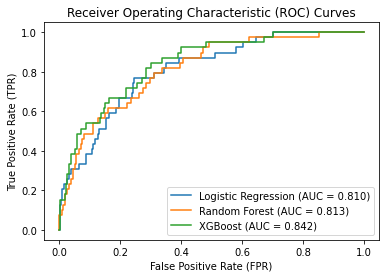

In [64]:
fpr_xgbbasic, tpr_xgbbasic, thresholds = metrics.roc_curve(Y_test, test_pred_prob)

plt.plot(fpr_LRBasic, tpr_LRBasic, label='Logistic Regression (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_LRpredprob_test[:,1])))
plt.plot(fpr_RFbasic, tpr_RFbasic, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_RFpredProb_test)))
plt.plot(fpr_xgbbasic, tpr_xgbbasic, label='XGBoost (AUC = {:.3f})'.format(roc_auc_score(Y_test, test_pred_prob)))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

#### Basic SVM

In [65]:
kernels = list(['linear'])
c = list(range(-5,5,3))
# gammas = list([0.1, 1, 10])
clf = SVC(class_weight='balanced')
param_grid = dict(kernel=kernels, C=c)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_, grid.best_score_


10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "d:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 189, in sklearn.svm._libsvm.fit
ValueError: C <= 0

One or more of the test scores are non-finite: 

({'C': 1, 'kernel': 'linear'}, 0.8239386396035062)

In [66]:
gammas = list([0.001, 0.01, 0.1, 1, 10])
clf = SVC(C = 1, kernel='linear',  class_weight='balanced')
clf.fit(X_train, Y_train)
param_grid = dict(gamma = gammas)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_, grid.best_score_

({'gamma': 0.001}, 0.8239386396035062)

In [67]:
SVMModel = SVC(C = 1, kernel='linear', gamma=0.001, class_weight='balanced', probability=True).fit(X_train, Y_train)
y_SVMpred_test = SVMModel.predict(X_test)
y_SVMpredprob_test = SVMModel.predict_proba(X_test)
y_SVMpredprob_train = SVMModel.predict_proba(X_train)

report_pre = classification_report(Y_test, y_SVMpred_test, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.977982,0.746499,0.846704,714.000000
1,0.129808,0.692308,0.218623,39.000000
accuracy,0.743692,0.743692,0.743692,0.743692
macro avg,0.553895,0.719403,0.532664,753.000000
weighted avg,0.934052,0.743692,0.814174,753.000000


In [68]:
roc_auc_score(Y_train, y_SVMpredprob_train[:,1]), roc_auc_score(Y_test, y_SVMpredprob_test[:,1])

(0.8496326662191819, 0.7948358830711773)

In [ ]:
new_threshold = 0.026
y_new_prediction = np.where(y_SVMpredprob_test[:,1] >= new_threshold, 1, 0)
report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
pd.DataFrame(report_pre).T

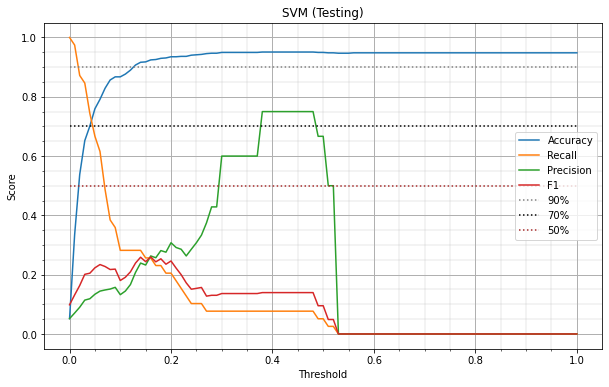

In [94]:
f_one_SVM, acc_SVM, recall_SVM, precision_SVM = Metrics_TradeOff_Plot(y_SVMpredprob_test[:,1], 
                Y_test, 'SVM (Testing)', "./figures/Tradeoff_SVM_basic_test.png")

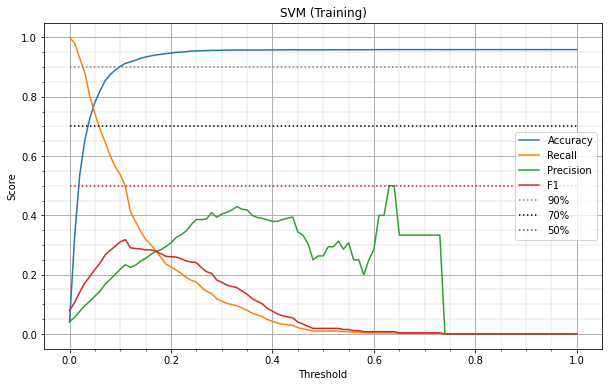

In [93]:
f_one_SVMtr, acc_SVMtr, recall_SVMtr, precision_SVMtr = Metrics_TradeOff_Plot(y_SVMpredprob_train[:,1], 
                Y_train, 'SVM (Training)', "./figures/Tradeoff_SVM_basic_train.png")

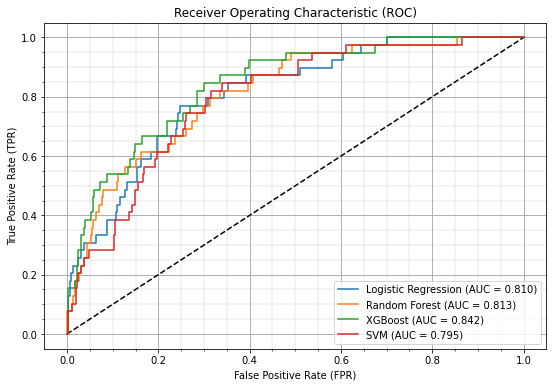

In [72]:
fpr_SVMbasic, tpr_SVMbasic, thresholds = metrics.roc_curve(Y_test, y_SVMpredprob_test[:,1])

x = np.linspace(0, 1, 100)
y = x
plt.figure(figsize=(9,6))
plt.plot(x, y, linestyle='dashed', color='black')
plt.plot(fpr_LRBasic, tpr_LRBasic, label='Logistic Regression (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_LRpredprob_test[:,1])))
plt.plot(fpr_RFbasic, tpr_RFbasic, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_RFpredProb_test)))
plt.plot(fpr_xgbbasic, tpr_xgbbasic, label='XGBoost (AUC = {:.3f})'.format(roc_auc_score(Y_test, test_pred_prob)))
plt.plot(fpr_SVMbasic, tpr_SVMbasic, label='SVM (AUC = {:.3f})'.format(roc_auc_score(Y_test, y_SVMpredprob_test[:,1])))

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.3)
plt.minorticks_on()
# plt.show()
plt.savefig("./figures/ROC_All_Features_21.png")

#### 2nd Version

In [ ]:
np.array(list(shapImportance_XGB & shapImportance_RF)).reshape((1,-1)), len(list(shapImportance_XGB & shapImportance_RF))

In [ ]:
predictorList_new = list(shapImportance_XGB & shapImportance_RF)

binaryList_using = list(set(binaryList) & set(predictorList_new))
freq = ['HouseType', 'RoofType', 'WaterSource']
freqList = [f"{i}_feq" for i in freq]
freqList_using = list(set(freqList) & set(predictorList_new))
nonstdList_using = list(set(nonstdList) & set(predictorList_new))
standardizationList_using = list(set(predictorList_new) - set(binaryList_using) - set(freqList_using) - set(nonstdList_using))

In [ ]:
X_train_org = StdTrain['train_9'][predictorList_new]
Y_train_org = StdTrain['train_9']['FCSStaus']

X_test_org = StdTest['test_9'][predictorList_new]
Y_test_org = StdTest['test_9']['FCSStaus']

X_train_org.reset_index(drop=True,inplace=True)
X_test_org.reset_index(drop=True,inplace=True)
Y_train_org.reset_index(drop=True,inplace=True)
Y_test_org.reset_index(drop=True,inplace=True)

X_smote, Y_smote, X_ADA, Y_ADA = resampling(X_train_org, Y_train_org)

print(X_smote.shape, Y_smote.shape, X_test_org.shape, Y_test_org.shape)

#### LR

In [ ]:
X_train = X_ADA
Y_train = Y_ADA

X_test = X_test_org
Y_test = Y_test_org

scoring = 'roc_auc'

LR_l1 = LogisticRegression(penalty='l1',random_state=527, solver='liblinear' ,
                           max_iter=1000, class_weight = 'balanced')

grid = {"C":[10**i for i in range(-2,2,1)]}
crossval = GridSearchCV(LR_l1,grid,cv=5,scoring=scoring)

crossval.fit(X_train, Y_train)
crossval.best_params_

In [ ]:
LR_l1 = LogisticRegression(penalty='l1',random_state=527,max_iter=1000,C=10, solver='liblinear' ,
                           class_weight = 'balanced')

LR_l1 = LogisticRegression(max_iter=1000)
LR_l1.fit(X_train, Y_train)

y_LRpred_test = LR_l1.predict(X_test)
y_LRpredprob_test = LR_l1.predict_proba(X_test)
y_LRpredprob_train = LR_l1.predict_proba(X_train)
report_test = classification_report(Y_test, y_LRpred_test,output_dict=True)
pd.DataFrame(report_test).T, confusion_matrix(Y_test, y_LRpred_test)

In [ ]:
roc_auc_score(Y_train, y_LRpredprob_train[:,1]) ,roc_auc_score(Y_test, y_LRpredprob_test[:,1])

In [ ]:
fpr_LRBasic, tpr_LRBasic, thresholds = metrics.roc_curve(Y_test, y_LRpredprob_test[:,1])
roc_auc_LRBasic = metrics.auc(fpr_LRBasic, tpr_LRBasic)
display = metrics.RocCurveDisplay(fpr=fpr_LRBasic, tpr=tpr_LRBasic, roc_auc=roc_auc_LRBasic,
                               estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
X_present = X_train.sample(frac=0.1)
explainer = shap.Explainer(LR_l1, masker=X_present)
shap_values = explainer(X_present)
shap.plots.beeswarm(shap_values, max_display = 20)

#### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train = X_smote
Y_train = Y_smote

X_test = X_test_org
Y_test = Y_test_org

# scoring = make_scorer(recall_score, greater_is_better=True, average='binary')
scoring = 'roc_auc'

RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[100],'max_depth':[3, 5,7], 'max_features' : [3,5,7]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)

crossval_rf.fit(X_train, Y_train)
crossval_rf.best_params_

In [ ]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[10],'max_depth':[18], 'max_features' : [8]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)
# crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring='roc_auc')

crossval_rf.fit(X_train, Y_train)
crossval_rf.best_params_

In [ ]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, **crossval_rf.best_params_, 
                            class_weight='balanced')

RF.fit(X_train, Y_train)
y_RFpredProb_train = RF.predict_proba(X_train)[:, 1]
y_RFpred_test = RF.predict(X_test)
y_RFpredProb_test = RF.predict_proba(X_test)[:, 1]

report_pre = classification_report(Y_test, y_RFpred_test, output_dict=True)
pd.DataFrame(report_pre).T

In [ ]:
roc_auc_score(Y_train, y_RFpredProb_train), roc_auc_score(Y_test, y_RFpredProb_test)

In [ ]:
y_RFpred_train = RF.predict(X_train)
report_train = classification_report(Y_train,y_RFpred_train,output_dict=True)
pd.DataFrame(report_train).T

In [ ]:
def Flexible_test_prediction(new_threshold):
    res = np.where(y_RFpredProb_test >= new_threshold, 1, 0)
    return res
new_new_threshold = np.arange(0,101,1)/100

y_new_prediction = map(Flexible_test_prediction, new_new_threshold)
newpred1 = np.array(list(y_new_prediction))
f_one_RF = []
acc_RF = []
recall_RF = []
precision_RF = []
for i in range(newpred1.shape[0]):
    newpredloop = newpred1[i,:].reshape((-1,1))
    f_one_RF.append(f1_score(Y_test,newpredloop))
    acc_RF.append(accuracy_score(Y_test, newpredloop))
    recall_RF.append(recall_score(Y_test, newpredloop))
    precision_RF.append(precision_score(Y_test,newpredloop , zero_division = 0))
    
plt.figure(figsize=(10,6))
plt.plot(new_new_threshold, acc_RF, label='Accuracy')
plt.plot(new_new_threshold, recall_RF, label='Recall')
plt.plot(new_new_threshold, precision_RF, label='Precision')
plt.plot(new_new_threshold, f_one_RF, label='F1')
plt.hlines(y = 0.9, xmin=0, xmax=1, linestyles="dotted", colors="gray", label='90%')
plt.hlines(y = 0.7, xmin=0, xmax=1, linestyles='dotted', colors="black", label='70%')
plt.hlines(y = 0.5, xmin=0, xmax=1, linestyles='dotted', colors="brown", label='50%')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Random Forest Version 1')
plt.legend()
plt.savefig("./figures/Tradeoff_RF_v1.png")

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(RF, StdTest['test_9'][predictorList], StdTest['test_9']['FCSStaus'], cmap=plt.cm.Blues)
plot_confusion_matrix(RF, X_test, Y_test, cmap=plt.cm.Blues)
plt.show()

In [ ]:
importances = RF.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(20, 6))
forest_importances.sort_values().plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [ ]:
X_present = X_train.sample(frac=0.1)
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)

#### 2nd XGBoost

In [ ]:
X_train = X_ADA
Y_train = Y_ADA

X_test = X_test_org
Y_test = Y_test_org
# scoring = make_scorer(recall_score, greater_is_better=True, average='binary')
scoring = 'roc_auc'
DataTrain = pd.concat([X_train,Y_train],axis=1)
xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=1,
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb1, DataTrain, predictorList_new, X_test=X_test, Y_test=Y_test)

In [ ]:
xgb_estimator.get_params

In [ ]:
# param_test1 = {
#  'max_depth':range(1,6,2),
#  'min_child_weight':range(1,8,2)
# }
param_test1 = {
 'max_depth':[3],
 'min_child_weight': [9,10,11]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring=scoring, n_jobs=-1, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.05, n_estimators=1000, **gsearch1.best_params_, 
 gamma=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb1, DataTrain, predictorList_new, X_test=X_test, Y_test=Y_test)

In [ ]:
xgb_estimator.get_params

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)],'max_depth': [3], 'min_child_weight': [9]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=1000, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring=scoring, n_jobs=-1, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = XGBClassifier( learning_rate =0.05, n_estimators=1000, **gsearch3.best_params_, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb2, DataTrain, predictorList_new, X_test=X_test, Y_test=Y_test)

In [ ]:
xgb_estimator.get_params

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(5,8)],
 'colsample_bytree':[i/10.0 for i in range(5,8)],
 'gamma':[1],'max_depth': [3], 'min_child_weight': [9]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=1000, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring=scoring ,n_jobs=-1, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test6 = {
     'subsample':[0.7],
 'colsample_bytree':[0.7],
 'gamma':[1],'max_depth': [3], 'min_child_weight': [9], 
 'reg_alpha':[10, 20,30,50,100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring=scoring , n_jobs=-1, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_, gsearch6.best_score_

In [ ]:
xgb3 = XGBClassifier( learning_rate =0.05, n_estimators=1000, **gsearch6.best_params_, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb3, DataTrain, predictorList_new, X_test=X_test, Y_test=Y_test)

In [ ]:
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=5000, **gsearch6.best_params_,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb4, DataTrain, predictorList_new, X_test=X_test, Y_test=Y_test)

In [ ]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

In [ ]:
confusion_matrix(Y_test,test_pred_class)

In [ ]:
new_threshold = 0.2
y_new_prediction = np.where(test_pred_prob >= new_threshold, 1, 0)
report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
pd.DataFrame(report_pre).T

In [ ]:
def Flexible_test_prediction(new_threshold):
    res = np.where(test_pred_prob >= new_threshold, 1, 0)
    return res
new_new_threshold = np.arange(0,101,1)/100

y_new_prediction = map(Flexible_test_prediction, new_new_threshold)
newpred1 = np.array(list(y_new_prediction))
f_one_XGB = []
acc_XGB = []
recall_XGB = []
precision_XGB = []
for i in range(newpred1.shape[0]):
    newpredloop = newpred1[i,:].reshape((-1,1))
    f_one_XGB.append(f1_score(Y_test,newpredloop))
    acc_XGB.append(accuracy_score(Y_test, newpredloop))
    recall_XGB.append(recall_score(Y_test, newpredloop))
    precision_XGB.append(precision_score(Y_test,newpredloop , zero_division = 0))
    
plt.figure(figsize=(10,6))
plt.plot(new_new_threshold, acc_XGB, label='Accuracy')
plt.plot(new_new_threshold, recall_XGB, label='Recall')
plt.plot(new_new_threshold, precision_XGB, label='Precision')
plt.plot(new_new_threshold, f_one_XGB, label='F1')
plt.hlines(y = 0.9, xmin=0, xmax=1, linestyles="dotted", colors="gray", label='90%')
plt.hlines(y = 0.7, xmin=0, xmax=1, linestyles='dotted', colors="black", label='70%')
plt.hlines(y = 0.5, xmin=0, xmax=1, linestyles='dotted', colors="brown", label='50%')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('XGBoost Version 1')
plt.legend()
plt.savefig("./figures/Tradeoff_XGB_v1.png")

In [ ]:
confusion_matrix(Y_test,y_new_prediction)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                               estimator_name='example estimator')
display.plot()
plt.show()

#### 2nd SVM

In [ ]:
kernels = list(['rbf'])
c = list([0.001,0.01, 0.1, 1])
# gammas = list([0.1, 1, 10])

X_train = X_smote
Y_train = Y_smote

X_test = X_test_org
Y_test = Y_test_org

clf = SVC(class_weight='balanced')
param_grid = dict(kernel=kernels, C=c)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_, grid.best_score_

In [ ]:
c = list([100, 200, 500])

clf = SVC(kernel = 'rbf', class_weight='balanced')
param_grid = dict(C=c)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_, grid.best_score_

In [ ]:
gammas = list([0.01, 0.1, 1, 10])
clf = SVC(C = 100, kernel='rbf',  class_weight='balanced')
clf.fit(X_train, Y_train)
param_grid = dict(gamma = gammas)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_,  grid.best_score_

In [ ]:
gammas = list([10,15,20])
clf = SVC(C = 100, kernel='rbf',  class_weight='balanced')
clf.fit(X_train, Y_train)
param_grid = dict(gamma = gammas)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_,  grid.best_score_

In [ ]:
SVMModel = SVC(C = 100, kernel='rbf', gamma=10, class_weight='balanced', probability=True).fit(X_train, Y_train)
y_SVMpred_test = SVMModel.predict(X_test)
y_SVMpredprob_test = SVMModel.predict_proba(X_test)
y_SVMpredprob_train = SVMModel.predict_proba(X_train)

report_pre = classification_report(Y_test, y_SVMpred_test, output_dict=True)
pd.DataFrame(report_pre).T

In [ ]:
roc_auc_score(Y_train, y_SVMpredprob_train[:,1]), roc_auc_score(Y_test, y_SVMpredprob_test[:,1])